# Example: Material selection for beam strength

---

This notebook creates the results reported in Section II. Motivation: Materials Indices and Selection. The example is of a strength-constrained cantilever beam, comparing the materials Ti6Al4V (better nominally, higher variability) and Al 7075-T6 (worse nominally, smaller variability).


In [1]:
import grama as gr
import numpy as np
import pandas as pd
import scipy as sp

DF = gr.Intention()

### Model setup

---

Use a Grama model to package all calculations in the median materials index (MMI) and precision materials index (PMI).


In [2]:
## Strength-constrained cantilever beam parameters 
p = +2
q = -3
w_rho = +0
w_s   = -1
v_rho = +1
v_s   = +0

## Package all expressions as a Grama model
md_indices = (
    gr.Model("Cantilever beam strength indices")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            mu_w=w_rho * df.mu_rho + w_s * df.mu_s,
            mu_v=v_rho * df.mu_rho + v_s * df.mu_s,
            sig_w=np.sqrt(w_rho**2 * df.sig_rho**2 + w_s**2 * df.sig_s**2),
            sig_v=np.sqrt(v_rho**2 * df.sig_rho**2 + v_s**2 * df.sig_s**2),
        ),
        var=["mu_rho", "mu_s", "sig_rho", "sig_s"],
        out=["mu_w", "mu_v", "sig_w", "sig_v"],
        name="Param.",
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            MMI=np.exp(p/q * df.mu_w - df.mu_v),
        ),
        var=["mu_w", "mu_v"],
        out=["MMI"],
        name="MMI",
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            b=sp.stats.nct.ppf(df.C, df.n, np.sqrt(df.n) * df.beta_t) / np.sqrt(df.n)
             -df.beta_t
        ),
        var=["C", "n", "beta_t"],
        out=["b"],
        name="MIB",
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            f_beta_t=np.exp(p/q * df.beta_t * df.sig_w),
            f_b=np.exp(p/q * df.b * df.sig_w),
        ),
        var=["beta_t", "b", "sig_w"],
        out=["f_beta_t", "f_b"],
        name="RBDO",
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            RMI=df.MMI * df.f_beta_t,
            PMI=df.MMI * df.f_beta_t * df.f_b,
            kappa=1 - df.f_beta_t * df.f_b,
        ),
        var=["MMI", "f_beta_t", "f_b"],
        out=["RMI", "PMI", "kappa"],
        name="fin"
    )
)
md_indices


model: Cantilever beam strength indices

  inputs:
    var_det:
      C: (unbounded)
      mu_s: (unbounded)
      sig_rho: (unbounded)
      beta_t: (unbounded)
      mu_rho: (unbounded)
      n: (unbounded)
      sig_s: (unbounded)

    var_rand:

    copula:
      None

  functions:
      Param.: ['mu_rho', 'mu_s', 'sig_rho', 'sig_s'] -> ['mu_w', 'mu_v', 'sig_w', 'sig_v']
      MMI: ['mu_w', 'mu_v'] -> ['MMI']
      MIB: ['C', 'n', 'beta_t'] -> ['b']
      RBDO: ['beta_t', 'b', 'sig_w'] -> ['f_beta_t', 'f_b']
      fin: ['MMI', 'f_beta_t', 'f_b'] -> ['RMI', 'PMI', 'kappa']

This printout lists all quantities needed to compute materials indices for the strength-constrained beam.

Visualize the relation between quantities with a directed acyclic graph (DAG):


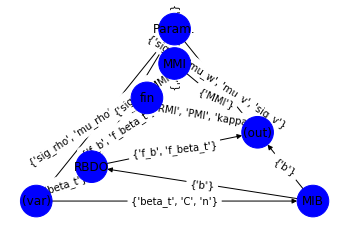

In [3]:
md_indices.show_dag()


### Parameter setup

---




In [4]:
df_param = (
    ## From Table 3: Metallic properties
    gr.df_make(
        material=["AL 7075-T6", "Ti 6Al 4V", "Al 6061-T6"],
        mean_rho=[1.020e-1, 1.600e-1, 9.750e-2],
        mean_s=[7.300e+4, 1.600e+5, 4.000e+4],
        cov_rho=[0.01, 0.02, 0.01],
        cov_s=[0.01, 0.06, 0.03],
    )
    ## Transform parameters for lognormal marginals
    >> gr.tf_mutate(
        # Approximate sig = COV
        sig_rho=DF.cov_rho,
        sig_s=DF.cov_s,
    )
    >> gr.tf_mutate(
        # Equate mu = log(mean) - sig**2/2
        mu_rho=gr.log(DF.mean_rho) - DF.sig_rho**2 / 2,
        mu_s=gr.log(DF.mean_s) - DF.sig_s**2 / 2,
    )
)
df_param


,material,mean_rho,mean_s,cov_rho,cov_s,sig_rho,sig_s,mu_rho,mu_s
0,AL 7075-T6,0.1020,73000.0,0.01,0.01,0.01,0.01,-2.282832,11.198165
1,Ti 6Al 4V,0.1600,160000.0,0.02,0.06,0.02,0.06,-1.832781,11.981129
2,Al 6061-T6,0.0975,40000.0,0.01,0.03,0.01,0.03,-2.327953,10.596185


### Compute indices

---

Compute MMI and PMI values for all materials.


In [5]:
(
    md_indices
    >> gr.ev_df(
        df=df_param
        >> gr.tf_outer(
            ## Define two scenarios of sample size
            gr.df_make(
                C=0.95,
                n=[10, 100],
                beta_t=3.0,
            )
        )
    )
    >> gr.tf_mutate(
        log_MMI=np.round(gr.log(DF.MMI), decimals=2),
        log_PMI=np.round(gr.log(DF.PMI), decimals=2),
    )
    >> gr.tf_select(
        "material",
        "n",
        "log_MMI",
        "log_PMI",
        "kappa",
    )
)

,material,n,log_MMI,log_PMI,kappa
0,AL 7075-T6,10,9.75,9.72,0.032184
1,Ti 6Al 4V,10,9.82,9.62,0.178216
2,Al 6061-T6,10,9.39,9.29,0.093477
3,AL 7075-T6,100,9.75,9.73,0.022647
4,Ti 6Al 4V,100,9.82,9.68,0.128416
5,Al 6061-T6,100,9.39,9.32,0.066413


As reported in the text of the manuscript, Ti6Al4V appears to be superior (have a higher index) in terms of the MMI, but when accounting for knockdowns due to process variability and sampling uncertainty via the PMI, Al 7075-T6 is superior.
